# HITI-Preproc -- Example Notebook

In [1]:
import pydicom
import os
import pandas as pd
import numpy as np
import hiti_preproc as hp
import matplotlib.pyplot as plt
from dotenv import load_dotenv

## 0. Load Example Image

In [2]:
# load environment variables
load_dotenv()

# load EMBED image metadata to sample an example image
meta_path: str = os.environ["METADATA_PATH"]
meta_df = pd.read_csv(meta_path)


/tmp/ipykernel_120334/1827453952.py:6: DtypeWarning: Columns (0,2,3,4,41,43,64,68,71,74,82,89,91,101,103,104,106,108,110,111,112,113,114,115,116,117,118,128,130,131,132,133,134,136,141,145,146,147,148,153,158,159) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv(meta_path)


In [3]:
# get a dataset of 2D mammograms from cohorts 1/2 (available in EMBED Open Data) 
# and exclude spot compression/magnification images
test_df: pd.DataFrame = meta_df[
    (meta_df.FinalImageType == "2D")
    & (meta_df.cohort_num.isin([1.0, 2.0]))
    & (meta_df.spot_mag != 1)
]

print(f"Unique DICOMs: {test_df.anon_dicom_path.nunique():,d}")

Unique DICOMs: 334,885


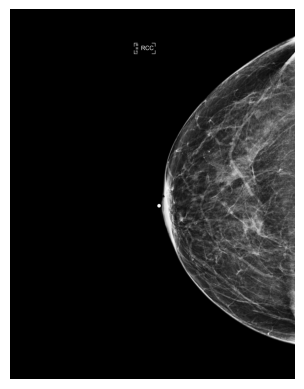

In [11]:
# randomly sample an image
test_row: pd.Series = test_df.sample(1).iloc[0]

# load the dicom
dicom: pydicom.FileDataset = pydicom.dcmread(test_row.anon_dicom_path)

# display the raw image
plt.imshow(dicom.pixel_array, cmap="gray")
plt.axis("off")
plt.show()

## 1. Preprocessing DICOM Pixel Arrays with VOI-LUT

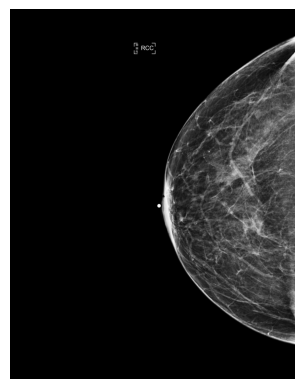

In [12]:
# apply the VOI-LUT transformation described by the DICOM and normalize to a uint16 image
preprocessed_image: np.ndarray = hp.preprocess_pixel_array(dicom)

# display the preprocessed image
plt.imshow(preprocessed_image, cmap="gray")
plt.axis("off")
plt.show()

## 2. Normalizing Mammogram Alignments

In [13]:
# assess the alignment of the image
alignment: str = hp.check_mammogram_alignment(preprocessed_image)
print(f"Image is aligned to the {'right' if alignment == 'R' else 'left'} side")

# the image can then be manually re-aligned as needed

Image is aligned to the right side


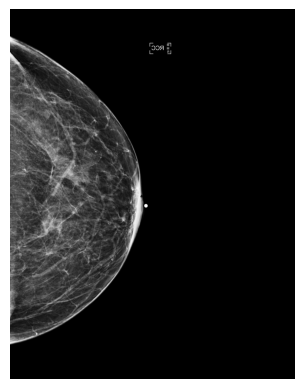

In [14]:
# the package also contains a wrapper function to normalize the alignment of an image to a target side
# in this case we'll re-align the image to the left side
realigned_image: np.ndarray = hp.normalize_mammogram_alignment(preprocessed_image, target_side="L")

# display the re-aligned image
plt.imshow(realigned_image, cmap="gray")
plt.axis("off")
plt.show()

## 3. Isolating Mammogram Foreground Pixels

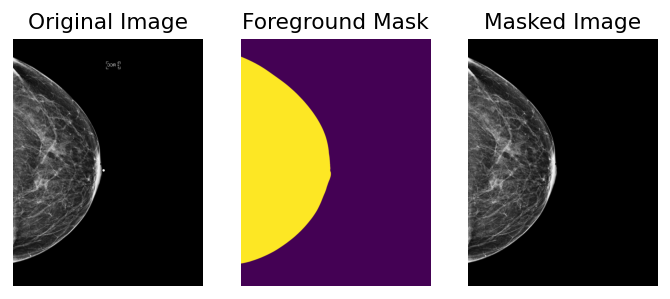

In [15]:
# get the foreground mask of the input image
foreground_mask: np.ndarray = hp.get_mammogram_foreground_mask(realigned_image)

# apply the foreground mask to the image by multiplying them together element-wise
masked_image: np.ndarray = realigned_image * foreground_mask

# display the image and its mask
fig, axes = plt.subplots(1, 3, dpi=130)

ax = axes[0]
ax.imshow(realigned_image, cmap="gray")
ax.axis("off")
ax.set_title("Original Image")

ax = axes[1]
ax.imshow(foreground_mask)
ax.axis("off")
ax.set_title("Foreground Mask")

ax = axes[2]
ax.imshow(masked_image, cmap="gray")
ax.axis("off")
ax.set_title("Masked Image")

plt.show()

## 4. Preprocessing Mammogram DICOMs in One Step

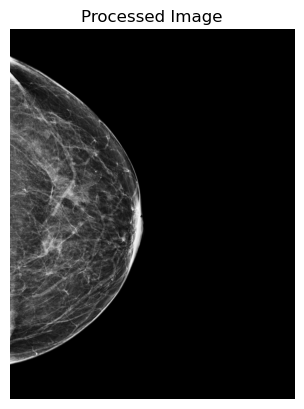

In [ ]:
# this package also includes a wrapper to handle the previous preprocessing steps in one line
output_image: np.ndarray = hp.preprocess_mammo_dicom(dicom, return_mask=False)

plt.imshow(output_image, cmap="gray")
plt.axis("off")
plt.title("Processed Image")
plt.show()


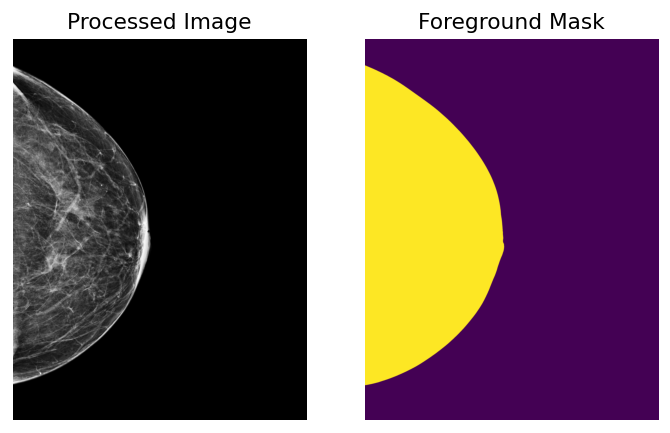

In [ ]:
# we can also output the foreground mask if return_mask is True (defaults to False)
output_image, output_fg_mask = hp.preprocess_mammo_dicom(dicom, return_mask=True)

# display the image and its mask
fig, axes = plt.subplots(1, 2, dpi=130)

ax = axes[0]
ax.imshow(output_image, cmap="gray")
ax.axis("off")
ax.set_title("Processed Image")

ax = axes[1]
ax.imshow(output_fg_mask)
ax.axis("off")
ax.set_title("Foreground Mask")

plt.show()